In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ML libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, accuracy_score, precision_recall_fscore_support)
from catboost import CatBoostClassifier, Pool

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

plt.style.use('ggplot')

In [4]:
# Prepare datasets
# CatBoost
X_train_cb = pd.read_csv('/content/drive/MyDrive/fraud detection/data/X_train_cb.csv')
y_train_cb = pd.read_csv('/content/drive/MyDrive/fraud detection/data/y_train_cb.csv')
X_val_cb = pd.read_csv('/content/drive/MyDrive/fraud detection/data/X_val_cb.csv')
y_val_cb = pd.read_csv('/content/drive/MyDrive/fraud detection/data/y_val_cb.csv')
X_test_cb = pd.read_csv('/content/drive/MyDrive/fraud detection/data/X_test_cb.csv')
y_test_cb = pd.read_csv('/content/drive/MyDrive/fraud detection/data/y_test_cb.csv')

# LR/MLP
X_train_lr = pd.read_csv('/content/drive/MyDrive/fraud detection/data/X_train_log.csv')
y_train_lr = pd.read_csv('/content/drive/MyDrive/fraud detection/data/y_train_log.csv')
X_val_lr = pd.read_csv('/content/drive/MyDrive/fraud detection/data/X_val_log.csv')
y_val_lr = pd.read_csv('/content/drive/MyDrive/fraud detection/data/y_val_log.csv')
X_test_lr = pd.read_csv('/content/drive/MyDrive/fraud detection/data/X_test_log.csv')
y_test_lr = pd.read_csv('/content/drive/MyDrive/fraud detection/data/y_test_log.csv')

In [5]:
# Evaluation functions
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Model evaluation"""
    print(f"{model_name} - EVALUATION RESULTS")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Non-Fraud', 'Fraud']))

    # Metrics
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    print(f"\nKey Metrics:")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    return roc_auc, acc, precision, recall, f1

In [6]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'],
                cbar_kws={'label': 'Count'})
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    print(f"\nConfusion Matrix:")
    print(f"  True Negatives:  {tn:,} | False Positives: {fp:,}")
    print(f"  False Negatives: {fn:,} | True Positives:  {tp:,}")


In [7]:
def plot_roc_curve_single(y_true, y_pred_proba, model_name):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


1. Logistic regression

In [8]:
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs',
    class_weight='balanced'
)

lr_model.fit(X_train_lr, y_train_lr)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [9]:
# Predictions
lr_pred_val = lr_model.predict(X_val_lr)
lr_pred_proba_val = lr_model.predict_proba(X_val_lr)[:, 1]

In [10]:
# Evaluate
lr_roc_auc, lr_acc, lr_prec, lr_rec, lr_f1 = evaluate_model(
    y_val_lr, lr_pred_val, lr_pred_proba_val, "Logistic Regression"
)

Logistic Regression - EVALUATION RESULTS

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.64      0.78      2174
       Fraud       0.13      0.82      0.22       139

    accuracy                           0.65      2313
   macro avg       0.56      0.73      0.50      2313
weighted avg       0.93      0.65      0.74      2313


Key Metrics:
  ROC-AUC:   0.8083
  Accuracy:  0.6533
  Precision: 0.1279
  Recall:    0.8201
  F1-Score:  0.2214


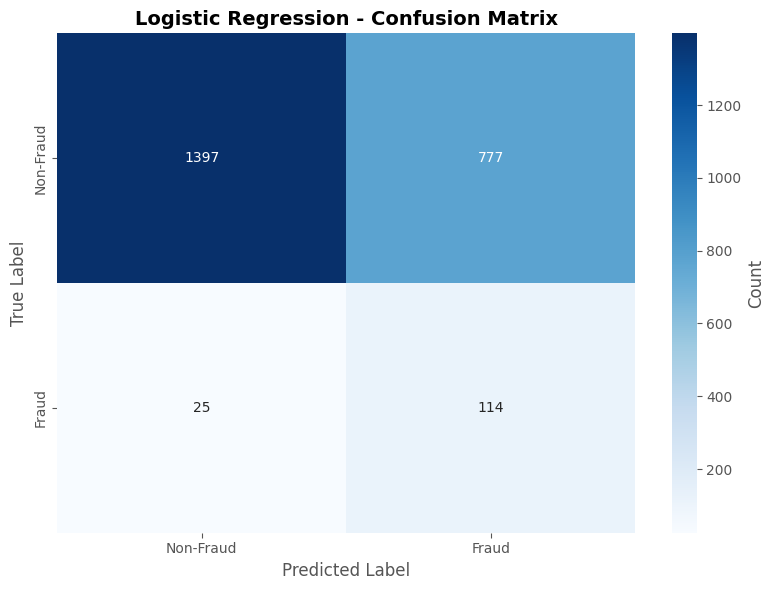


Confusion Matrix:
  True Negatives:  1,397 | False Positives: 777
  False Negatives: 25 | True Positives:  114


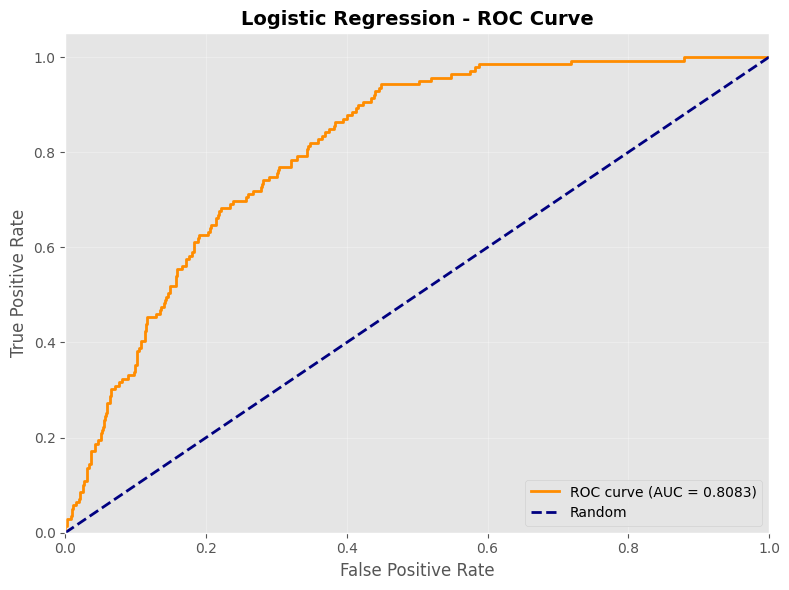

In [11]:
# Visualizations
plot_confusion_matrix(y_val_lr, lr_pred_val, "Logistic Regression")
plot_roc_curve_single(y_val_lr, lr_pred_proba_val, "Logistic Regression")

In [12]:
# Feature importance
feature_importance_lr = pd.DataFrame({
    'Feature': X_train_lr.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False).head(20)

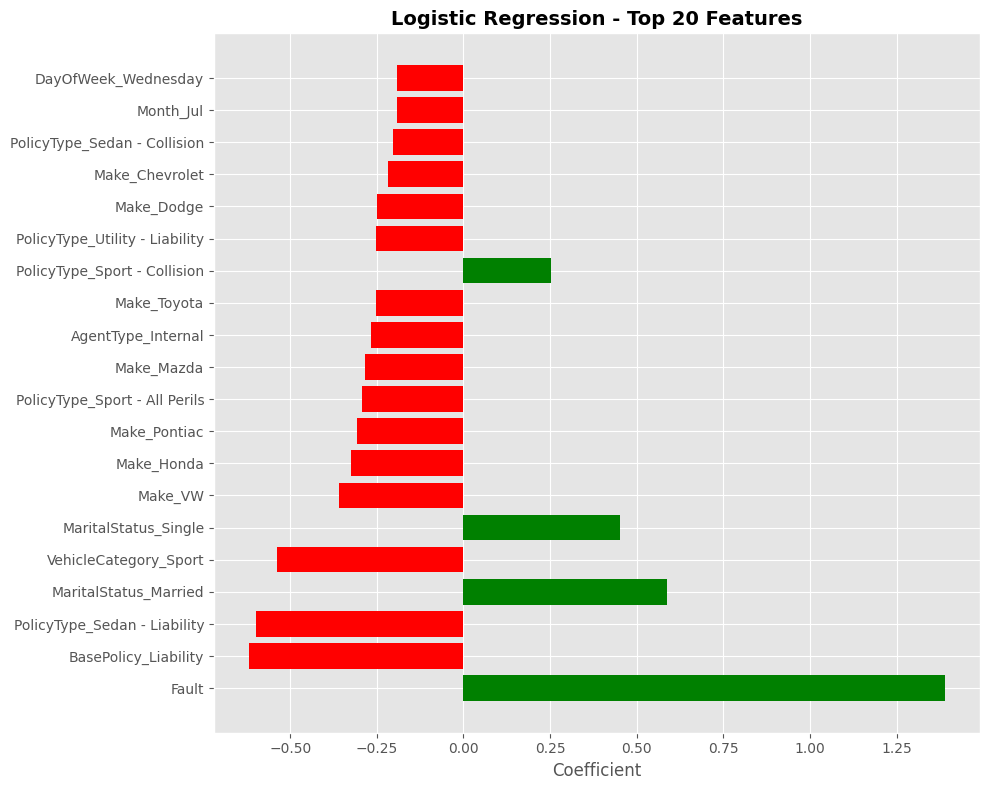

In [13]:
plt.figure(figsize=(10, 8))
colors = ['red' if x < 0 else 'green' for x in feature_importance_lr['Coefficient']]
plt.barh(feature_importance_lr['Feature'], feature_importance_lr['Coefficient'], color=colors)
plt.xlabel('Coefficient')
plt.title('Logistic Regression - Top 20 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
# Save model
joblib.dump(lr_model, '/content/drive/MyDrive/fraud detection/model/logistic_regression.pkl')

['/content/drive/MyDrive/fraud detection/model/logistic_regression.pkl']

2. CatBoost (with Native Categorical Handling)

In [15]:
cat_features = joblib.load('/content/drive/MyDrive/fraud detection/pkls/cat_features.pkl')

In [16]:
cat_feature_indices=X_train_cb.columns.get_indexer(cat_features)

In [17]:
# Create CatBoost Pool objects (for native categorical handling)
train_pool = Pool(
    data=X_train_cb,
    label=y_train_cb,
    cat_features=cat_feature_indices
)

val_pool = Pool(
    data=X_val_cb,
    label=y_val_cb,
    cat_features=cat_feature_indices
)

In [18]:
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50,
     auto_class_weights='Balanced',  # Handle imbalance automatically
    cat_features=cat_feature_indices  # Specify categorical features
)

In [19]:
catboost_model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    plot=False
)

0:	test: 0.7933375	best: 0.7933375 (0)	total: 139ms	remaining: 1m 9s
100:	test: 0.8491161	best: 0.8498441 (98)	total: 6.99s	remaining: 27.6s
200:	test: 0.8544373	best: 0.8558206 (163)	total: 16.5s	remaining: 24.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8558205873
bestIteration = 163

Shrink model to first 164 iterations.


In [20]:
# Predictions
cb_pred_val = catboost_model.predict(X_val_cb)
cb_pred_proba_val = catboost_model.predict_proba(X_val_cb)[:, 1]

In [21]:
# Evaluate
cb_roc_auc, cb_acc, cb_prec, cb_rec, cb_f1 = evaluate_model(
    y_val_cb, cb_pred_val, cb_pred_proba_val, "CatBoost"
)

CatBoost - EVALUATION RESULTS

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.76      0.86      2174
       Fraud       0.17      0.79      0.28       139

    accuracy                           0.76      2313
   macro avg       0.58      0.77      0.57      2313
weighted avg       0.93      0.76      0.82      2313


Key Metrics:
  ROC-AUC:   0.8558
  Accuracy:  0.7596
  Precision: 0.1727
  Recall:    0.7914
  F1-Score:  0.2835


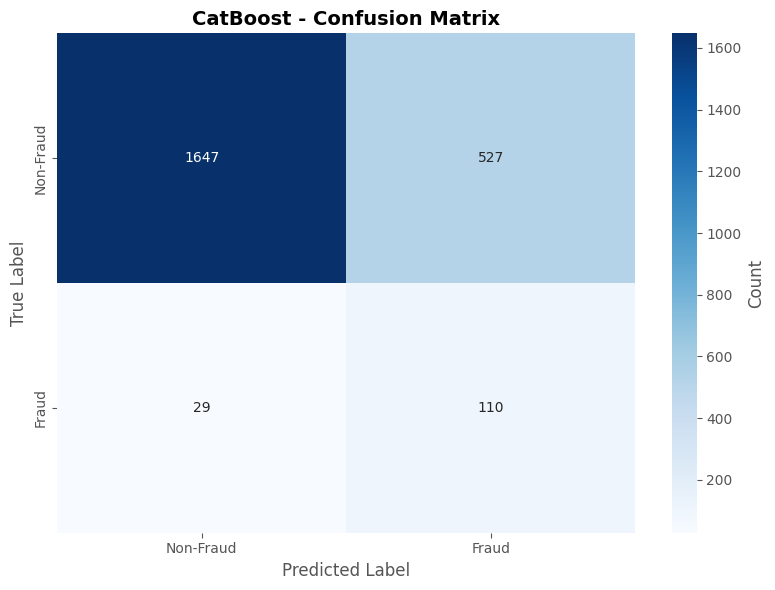


Confusion Matrix:
  True Negatives:  1,647 | False Positives: 527
  False Negatives: 29 | True Positives:  110


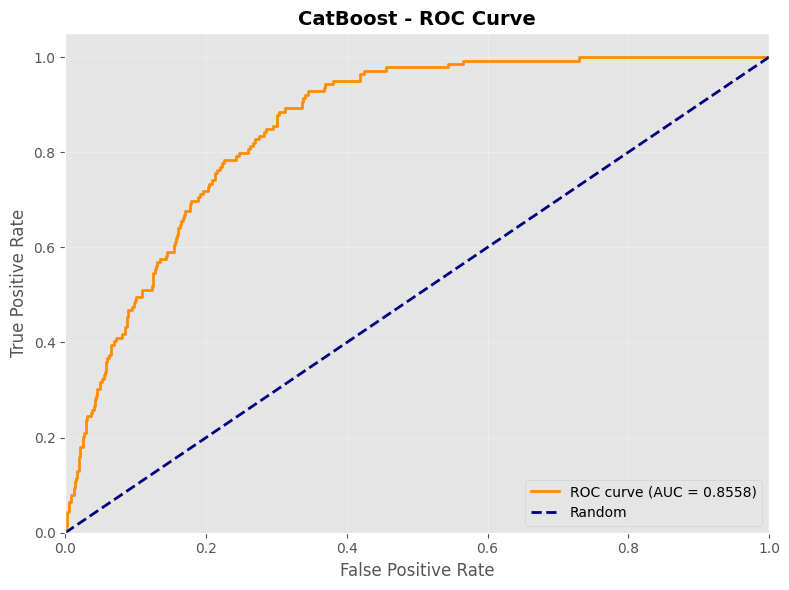

In [22]:
# Visualizations
plot_confusion_matrix(y_val_cb, cb_pred_val, "CatBoost")
plot_roc_curve_single(y_val_cb, cb_pred_proba_val, "CatBoost")


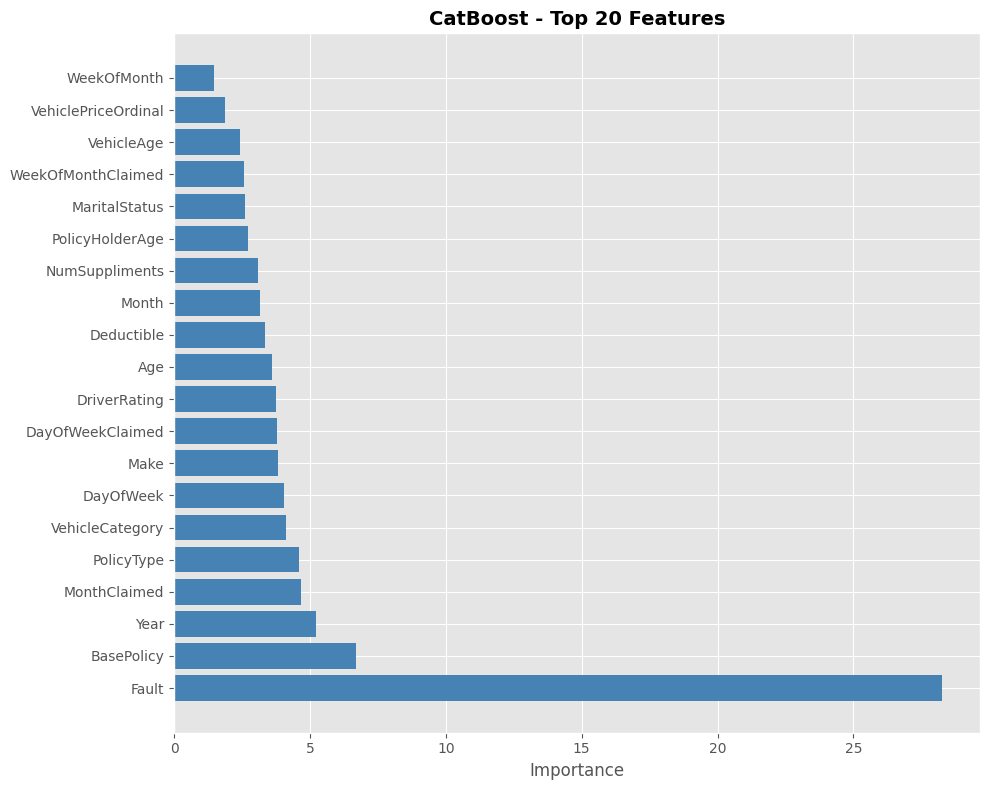

In [23]:
# Feature importance
feature_importance_cb = pd.DataFrame({
    'Feature': X_train_cb.columns,
    'Importance': catboost_model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_cb['Feature'], feature_importance_cb['Importance'],
         color='steelblue')
plt.xlabel('Importance')
plt.title('CatBoost - Top 20 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [24]:
# Save model
catboost_model.save_model('/content/drive/MyDrive/fraud detection/model/catboost_model.cbm')

3. Pytorch MLP

In [25]:
# Define MLP architecture
class FraudDetectionMLP(nn.Module):
    def __init__(self, input_dim):
        super(FraudDetectionMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),

            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)


In [33]:
# Prepare PyTorch data
X_train_tensor = torch.FloatTensor(X_train_lr.values)
y_train_tensor = torch.FloatTensor(y_train_lr.values).view(-1, 1)


X_val_tensor = torch.FloatTensor(X_val_lr.values)
y_val_tensor = torch.FloatTensor(y_val_lr.values).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [34]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [35]:
# Train MLP
input_dim = X_train_lr.shape[1]
mlp_model = FraudDetectionMLP(input_dim)

criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

In [36]:
num_epochs = 50
best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []
val_aucs = []

In [37]:
for epoch in range(num_epochs):
    # Training
    mlp_model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = mlp_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    mlp_model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = mlp_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            val_predictions.extend(outputs.numpy().flatten())
            val_targets.extend(y_batch.numpy().flatten())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_auc = roc_auc_score(val_targets, val_predictions)
    val_aucs.append(val_auc)

    scheduler.step(val_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(mlp_model.state_dict(), '/content/drive/MyDrive/fraud detection/model/mlp_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break


Epoch [5/50] - Train Loss: 0.2266, Val Loss: 0.3639, Val AUC: 0.7786
Epoch [10/50] - Train Loss: 0.1537, Val Loss: 0.3235, Val AUC: 0.7670
Epoch [15/50] - Train Loss: 0.1227, Val Loss: 0.3385, Val AUC: 0.7640
Epoch [20/50] - Train Loss: 0.0861, Val Loss: 0.3298, Val AUC: 0.7578
Epoch [25/50] - Train Loss: 0.0743, Val Loss: 0.3246, Val AUC: 0.7562

Early stopping at epoch 26


In [40]:
mlp_model.load_state_dict(torch.load('/content/drive/MyDrive/fraud detection/model/mlp_model.pth'))
print("✓ Best model loaded")

✓ Best model loaded


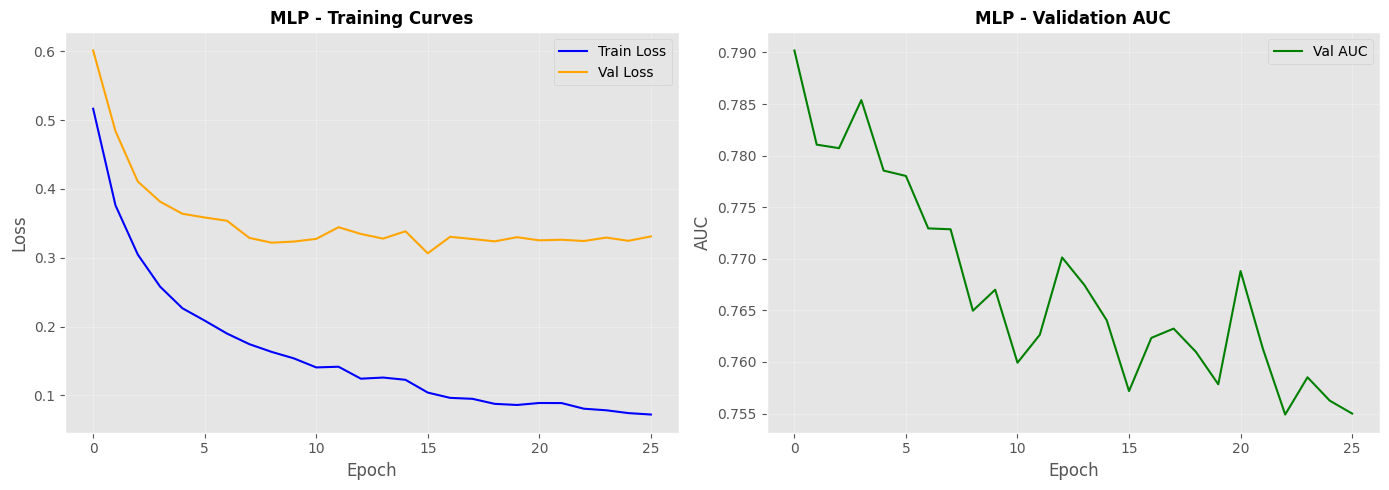

In [41]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss', color='blue')
axes[0].plot(val_losses, label='Val Loss', color='orange')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('MLP - Training Curves', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(val_aucs, label='Val AUC', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title('MLP - Validation AUC', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

PyTorch MLP - EVALUATION RESULTS

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.95      0.94      0.95      2174
       Fraud       0.21      0.25      0.23       139

    accuracy                           0.90      2313
   macro avg       0.58      0.60      0.59      2313
weighted avg       0.91      0.90      0.90      2313


Key Metrics:
  ROC-AUC:   0.7572
  Accuracy:  0.8980
  Precision: 0.2096
  Recall:    0.2518
  F1-Score:  0.2288


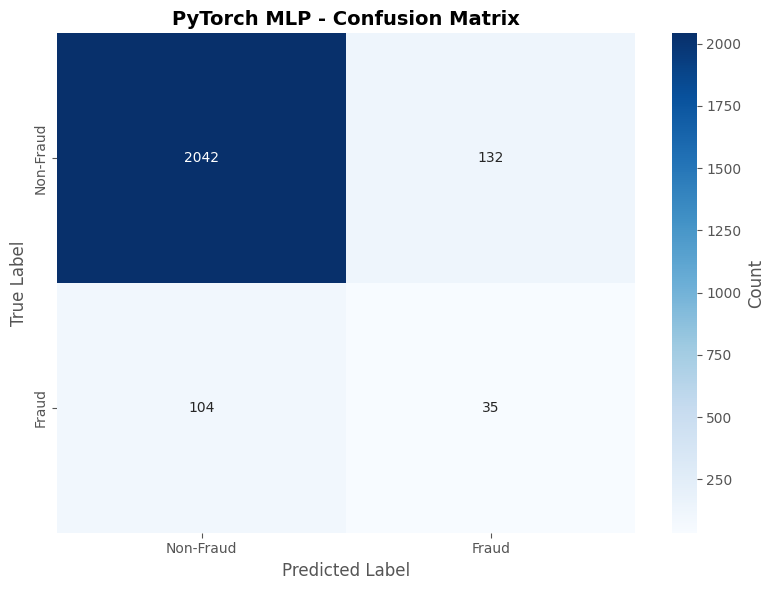


Confusion Matrix:
  True Negatives:  2,042 | False Positives: 132
  False Negatives: 104 | True Positives:  35


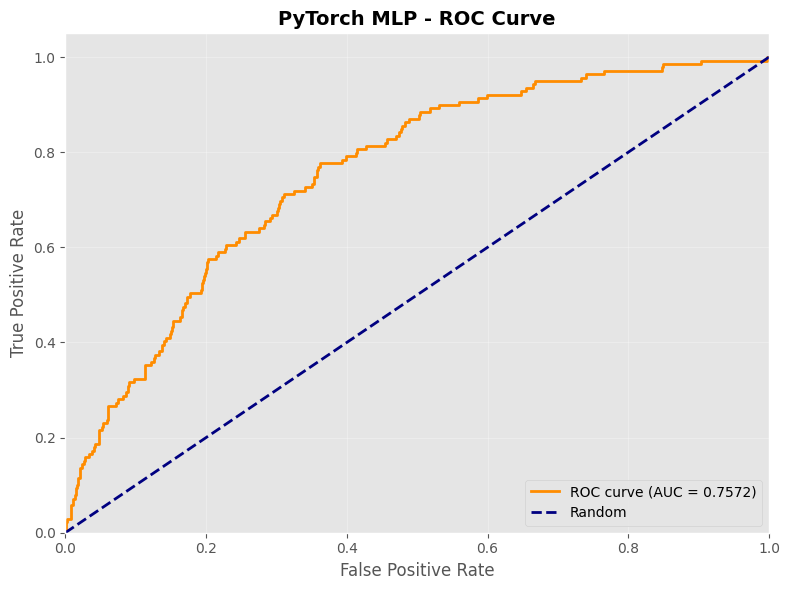

In [42]:
# Evaluate MLP
mlp_model.eval()
with torch.no_grad():
    mlp_pred_proba_val = mlp_model(X_val_tensor).squeeze().numpy()
    mlp_pred_val = (mlp_pred_proba_val > 0.5).astype(int)

mlp_roc_auc, mlp_acc, mlp_prec, mlp_rec, mlp_f1 = evaluate_model(
    y_val_lr, mlp_pred_val, mlp_pred_proba_val, "PyTorch MLP"
)

plot_confusion_matrix(y_val_lr, mlp_pred_val, "PyTorch MLP")
plot_roc_curve_single(y_val_lr, mlp_pred_proba_val, "PyTorch MLP")

4. Compare models

In [44]:
# Compare all models on validation set
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'CatBoost', 'PyTorch MLP'],
    'ROC-AUC': [lr_roc_auc, cb_roc_auc, mlp_roc_auc],
    'Accuracy': [lr_acc, cb_acc, mlp_acc],
    'F1-Score': [lr_f1, cb_f1, mlp_f1],
})

print("VALIDATION SET RESULTS")
print(comparison_df.to_string(index=False))


VALIDATION SET RESULTS
              Model  ROC-AUC  Accuracy  F1-Score
Logistic Regression 0.808333  0.653264  0.221359
           CatBoost 0.855821  0.759620  0.283505
        PyTorch MLP 0.757176  0.897968  0.228758


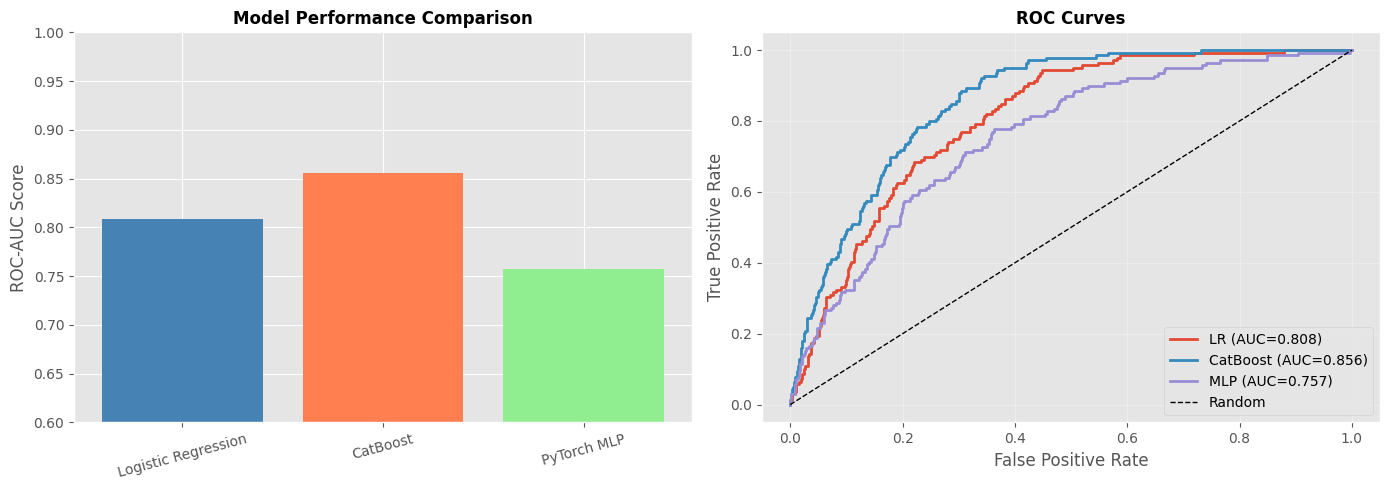

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC comparison
axes[0].bar(comparison_df['Model'], comparison_df['ROC-AUC'],
           color=['steelblue', 'coral', 'lightgreen'])
axes[0].set_ylabel('ROC-AUC Score')
axes[0].set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylim([0.6, 1.0])
axes[0].tick_params(axis='x', rotation=15)

# Combined ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_val_lr, lr_pred_proba_val)
axes[1].plot(fpr_lr, tpr_lr, lw=2, label=f'LR (AUC={lr_roc_auc:.3f})')

fpr_cb, tpr_cb, _ = roc_curve(y_val_cb, cb_pred_proba_val)
axes[1].plot(fpr_cb, tpr_cb, lw=2, label=f'CatBoost (AUC={cb_roc_auc:.3f})')

fpr_mlp, tpr_mlp, _ = roc_curve(y_val_lr, mlp_pred_proba_val)
axes[1].plot(fpr_mlp, tpr_mlp, lw=2, label=f'MLP (AUC={mlp_roc_auc:.3f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves', fontsize=12, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [48]:

# Test set evaluation

# Logistic Regression
lr_pred_test = lr_model.predict(X_test_lr)
lr_pred_proba_test = lr_model.predict_proba(X_test_lr)[:, 1]
lr_test_auc = roc_auc_score(y_test_lr, lr_pred_proba_test)

# CatBoost
cb_pred_test = catboost_model.predict(X_test_cb)
cb_pred_proba_test = catboost_model.predict_proba(X_test_cb)[:, 1]
cb_test_auc = roc_auc_score(y_test_cb, cb_pred_proba_test)

# PyTorch MLP
X_test_tensor = torch.FloatTensor(X_test_lr.values)
mlp_model.eval()
with torch.no_grad():
    mlp_pred_proba_test = mlp_model(X_test_tensor).numpy().flatten()
    mlp_pred_test = (mlp_pred_proba_test > 0.5).astype(int)
mlp_test_auc = roc_auc_score(y_test_lr, mlp_pred_proba_test)


In [49]:
# Final comparison
final_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'CatBoost', 'PyTorch MLP'],
    'Val AUC': [lr_roc_auc, cb_roc_auc, mlp_roc_auc],
    'Test AUC': [lr_test_auc, cb_test_auc, mlp_test_auc],
})

print(final_comparison.to_string(index=False))


              Model  Val AUC  Test AUC
Logistic Regression 0.808333  0.787786
           CatBoost 0.855821  0.851018
        PyTorch MLP 0.757176  0.758557


In [50]:
# Save comparison
final_comparison.to_csv('/content/drive/MyDrive/fraud detection/model/model_comparison.csv', index=False)

In [51]:
# %% Summary
best_model_idx = final_comparison['Test AUC'].idxmax()
best_model = final_comparison.loc[best_model_idx, 'Model']
best_auc = final_comparison.loc[best_model_idx, 'Test AUC']

print(f"🏆 Best Model: {best_model} (Test AUC: {best_auc:.4f})")

🏆 Best Model: CatBoost (Test AUC: 0.8510)
